In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [11]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [12]:
df["family_size"] = df["sibsp"] + df["parch"] + 1
df["is_alone"] = (df["family_size"] == 1).astype(int)

df["age"] = df["age"].fillna(df["age"].median())
df["embark_town"] = df["embark_town"].fillna(df["embark_town"].mode()[0])
df["fare"] = df["fare"].fillna(df["fare"].median())
df["deck"] = df["deck"].astype("object").fillna("Unknown")

target = "survived"
num_features = ["age", "fare", "family_size"]
cat_features = ["sex", "class", "embark_town", "deck", "who", "is_alone"]


In [13]:
X = df[num_features + cat_features]
Y = df[target]

In [14]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, kernel="rbf", random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

In [16]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=42
)


In [17]:
def evaluate_model(name, model):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("clf", model)])
    pipe.fit(X_Train, Y_Train)
    y_pred = pipe.predict(X_Test)
    y_proba = pipe.predict_proba(X_Test)[:,1] if hasattr(pipe, "predict_proba") else None
    
    metrics = {
        "Accuracy": accuracy_score(Y_Test, y_pred),
        "Precision": precision_score(Y_Test, y_pred),
        "Recall": recall_score(Y_Test, y_pred),
        "F1-score": f1_score(Y_Test, y_pred),
    }
    if y_proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(Y_Test, y_proba)
    else:
        metrics["ROC-AUC"] = np.nan
    
    return metrics



In [18]:
results = {}
for name, model in models.items():
    results[name] = evaluate_model(name, model)

results_df = pd.DataFrame(results).T
print("=== Model Comparison Results ===")
print(results_df)

=== Model Comparison Results ===
                        Accuracy  Precision    Recall  F1-score   ROC-AUC
Logistic Regression     0.815642   0.790323  0.710145  0.748092  0.862978
Decision Tree           0.759777   0.691176  0.681159  0.686131  0.735771
Random Forest           0.804469   0.765625  0.710145  0.736842  0.840448
Gradient Boosting       0.787709   0.762712  0.652174  0.703125  0.845191
Support Vector Machine  0.826816   0.839286  0.681159  0.752000  0.844664
K-Nearest Neighbors     0.815642   0.800000  0.695652  0.744186  0.844269


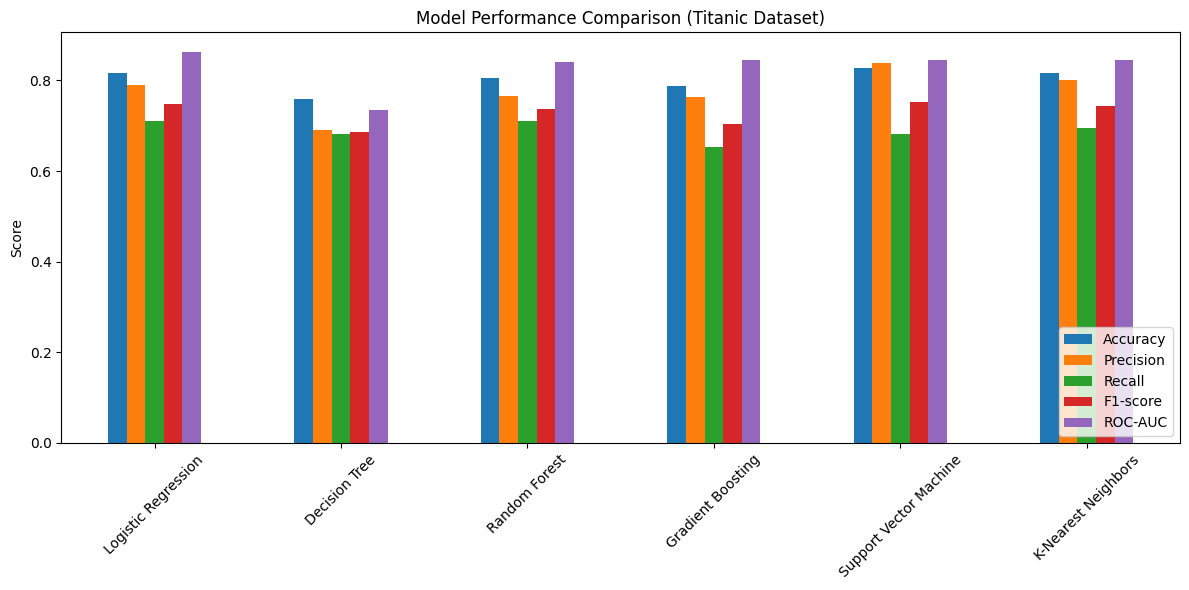

In [19]:
results_df.plot(kind="bar", figsize=(12,6))
plt.title("Model Performance Comparison (Titanic Dataset)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()